In [ ]:
import pandas as pd

# ---------- CONSTANTS ----------
FILE = 'comtrade_milk_uk_jan_jul_15.csv'   # change to your filename
REPORTER = 'United Kingdom'       # the country of interest
COMMODITY_KEYWORDS = ['milk', 'cream']  # filter commodity name for 'milk' and 'cream'
YEAR = 2015
# --------------------------------

df = pd.read_csv(FILE)

# quick checks
print("Columns:", df.columns.tolist())
print(df.head())


In [3]:
# Q1. How much does the UK export and import and is the balance positive (more exports than imports)?

# Filter for the specified year
df2015 = df[df['Year'] == YEAR]

# Filter for commodities containing the keywords
# Ensure 'Commodity' column is string type before applying .str.contains()
df2015_milk = df2015[
    df2015['Commodity'].astype(str).str.contains('|'.join(COMMODITY_KEYWORDS), case=False, na=False)
].copy()

# Ensure Trade Value numeric
df2015_milk['Trade Value (US$)'] = pd.to_numeric(df2015_milk['Trade Value (US$)'], errors='coerce').fillna(0)

# Filter rows where Reporter == United Kingdom
uk_trades = df2015_milk[df2015_milk['Reporter'] == REPORTER].copy()

# Sum by Trade Flow
totals = uk_trades.groupby('Trade Flow')['Trade Value (US$)'].sum().rename('Total_USD').reset_index()
print(totals)

  Trade Flow  Total_USD
0    Exports  530059323
1    Imports  312967953


In [5]:


exports = totals.loc[totals['Trade Flow'].str.lower().str.contains('export'), 'Total_USD'].sum()
imports = totals.loc[totals['Trade Flow'].str.lower().str.contains('import'), 'Total_USD'].sum()

balance = exports - imports
print(f"Exports (USD): {exports:,.0f}")
print(f"Imports (USD): {imports:,.0f}")
print(f"Trade balance (exports - imports): {balance:,.0f}")

if balance > 0:
    print("Balance is POSITIVE: UK exported more than it imported (for milk & cream).")
elif balance < 0:
    print("Balance is NEGATIVE: UK imported more than it exported.")
else:
    print("Balance is ZERO.")


Exports (USD): 530,059,323
Imports (USD): 312,967,953
Trade balance (exports - imports): 217,091,370
Balance is POSITIVE: UK exported more than it imported (for milk & cream).


In [ ]:
# Q2. Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?

# Top partners for exports FROM UK
exports_from_uk = uk_trades[uk_trades['Trade Flow'].str.lower().str.contains('export')]
top_export_partners = exports_from_uk.groupby('Partner')['Trade Value (US$)'].sum().nlargest(10)
print("Top export partners (to whom UK exported most):")
print(top_export_partners)

# Top partners for imports TO UK
imports_to_uk = uk_trades[uk_trades['Trade Flow'].str.lower().str.contains('import')]
top_import_partners = imports_to_uk.groupby('Partner')['Trade Value (US$)'].sum().nlargest(10)
print("\nTop import partners (from whom UK imported most):")
print(top_import_partners)




In [13]:
# Q3. Which are the regular customers (countries that buy milk from the UK every month)?

# Ensure we have a month value if Period is YYYYMM
df2015_milk['Period_str'] = df2015_milk['Period'].astype(str)
if df2015_milk['Period_str'].str.len().max() >= 6:
    df2015_milk['month'] = df2015_milk['Period_str'].str[4:6].astype(int)
else:
    # If Period is just year or missing months, this monthly question can't be answered
    raise ValueError("Data does not contain monthly Period values in YYYYMM format")

# Filter exports from UK and pivot by Partner x month
exports_monthly = df2015_milk[
    (df2015_milk['Reporter'] == REPORTER) &
    (df2015_milk['Trade Flow'].str.lower().str.contains('export'))
].copy()

# Create a flag for months with >0 value
exports_monthly['has_value'] = exports_monthly['Trade Value (US$)'] > 0

# Count months per partner with a positive export record
months_per_partner = exports_monthly.groupby('Partner')['month'].nunique().sort_values(ascending=False)
# partners with 12 months
regular_customers = months_per_partner[months_per_partner == 12].index.tolist()
print("Countries that bought from the UK every month in 2015:", regular_customers)

pivot = exports_monthly.pivot_table(index='Partner', columns='month', values='Trade Value (US$)', aggfunc='sum', fill_value=0)
regular_customers = pivot[(pivot > 0).all(axis=1)].index.tolist()
print("Countries that bought from the UK every month in 2015:", regular_customers)



Countries that bought from the UK every month in 2015: []
Countries that bought from the UK every month in 2015: ['Algeria', 'Areas, nes', 'Austria', 'Belgium', 'Cameroon', 'Canada', 'China', 'China, Hong Kong SAR', 'Congo', 'Cyprus', "Côte d'Ivoire", 'Denmark', 'Falkland Isds (Malvinas)', 'Finland', 'France', 'Germany', 'Greece', 'Guinea', 'Hungary', 'Ireland', 'Italy', 'Kuwait', 'Lebanon', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Qatar', 'Saudi Arabia', 'Singapore', 'South Africa', 'Spain', 'Sweden', 'United Arab Emirates', 'United States of America', 'World']


In [14]:
# Q4. Which countries does the UK both import from and export to?

export_partners = set(exports_from_uk['Partner'].unique())
import_partners = set(imports_to_uk['Partner'].unique())

both = sorted(list(export_partners.intersection(import_partners)))
print("Countries both exported to AND imported from in 2015:")
print(both)


Countries both exported to AND imported from in 2015:
['Austria', 'Belgium', 'Czech Rep.', 'Denmark', 'France', 'Germany', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Spain', 'Sweden', 'United Arab Emirates', 'United States of America', 'World']


In [15]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

# TASK 1

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("comtrade_milk_uk_monthly_14.csv")

# the first 5 rows
df.head()


In [ ]:
df.columns


In [18]:
df_clean = df[df["Partner"] != "World"].copy()


In [19]:
df_clean["Trade Value (US$)"] = pd.to_numeric(
    df_clean["Trade Value (US$)"],
    errors="coerce"
)


In [20]:
# Separate imports and exports

imports = df_clean[df_clean["Trade Flow"] == "Imports"]
exports = df_clean[df_clean["Trade Flow"] == "Exports"]


In [ ]:
# trading partners (Imports)

top_import_partners = (
    imports
    .groupby("Partner")["Trade Value (US$)"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_import_partners


In [ ]:
# trading partners (Exports)

top_export_partners = (
    exports
    .groupby("Partner")["Trade Value (US$)"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_export_partners


In [ ]:
df_clean["Period"].unique()[:12]


# Grouping Trade Data to Identify Significant Trading Partners

Using the dataset obtained in Exercise 1 from the UN Comtrade database, the data was grouped in multiple ways to identify the most significant trading partners under different conditions. Specifically, the analysis focused on:
Grouping trade data by commodity (or commodity code)
Grouping trade data by trade flow, commodity, and year
The significance of a trading partner was determined by the total trade value (US$) associated with that partner.

1. Grouping by Commodity (or Commodity Code)

Method:

To identify the most significant trading partner for each commodity, the data was grouped by commodity and partner country. The trade values were then aggregated and sorted in descending order to determine which partner accounted for the largest trade value for each commodity.

Outcome:

This grouping revealed that different commodities tend to have different dominant trading partners. In some cases, trade was highly concentrated with a single partner, while in others it was more evenly distributed across multiple countries. This suggests that the choice of commodity strongly influences trade relationships and partner dependence.

In [25]:
top_partner_by_commodity = (
    df_clean
    .groupby(["Commodity", "Partner"])["Trade Value (US$)"]
    .sum()
    .reset_index()
    .sort_values(["Commodity", "Trade Value (US$)"], ascending=[True, False])
    .groupby("Commodity")
    .head(1)
)

top_partner_by_commodity


,Commodity,Partner,Trade Value (US$)
49,"Milk and cream, concentrated or sweetened",Ireland,157826121
144,"Milk and cream, neither concentrated nor sweet...",Ireland,437718206


# Grouping by Trade Flow, Commodity, and Year

Method:

To further refine the analysis, the data was grouped by trade flow (imports or exports), commodity, and year, in addition to partner country. This made it possible to identify the most significant trading partner for each combination of trade direction and commodity within a given year.
Trade values were summed and the partner with the highest total value for each group was selected.

Outcome:

This grouping showed that:
The most important trading partner can differ between imports and exports for the same commodity.
Trade relationships may change over time, with some partners becoming more or less significant across different years.
Certain partners dominate exports, while others are primarily import sources.
This highlights the dynamic nature of international trade and the importance of analyzing trade data across multiple dimensions.

In [ ]:
top_partner_by_flow_commodity_year = (
    df_clean
    .groupby(["Trade Flow", "Commodity", "Year", "Partner"])["Trade Value (US$)"]
    .sum()
    .reset_index()
    .sort_values(
        ["Trade Flow", "Commodity", "Year", "Trade Value (US$)"],
        ascending=[True, True, True, False]
    )
    .groupby(["Trade Flow", "Commodity", "Year"])
    .head(1)
)

top_partner_by_flow_commodity_year

# Interpretation
Grouping the data in multiple ways provides deeper insight into international trade patterns. While a single country may be the dominant trading partner overall, breaking the data down by commodity and trade flow reveals more nuanced relationships. These results demonstrate that trade significance depends not only on the partner country, but also on the type of goods traded and the direction of trade.

# TASK 4

# Reflection on Grouping and Analysis of Trade Data

## 1. Grouping Strategy and Analytical Questions

To analyze the dataset, the data was grouped in several ways depending on the question being addressed. Initially, the data was grouped by **commodity (or commodity code)** and **partner country** in order to identify which countries were the most significant trading partners for each type of good. This grouping allowed for a comparison of trade relationships across different commodities and helped reveal whether trade was concentrated among a small number of partners or spread more evenly across many countries.

The data was also grouped by **trade flow (imports and exports)**, **commodity**, and **year**. This approach made it possible to ask more detailed questions, such as whether the most important partners differed between imports and exports, and whether these relationships changed over time. By aggregating trade values within each group, the analysis focused on identifying the partners that accounted for the largest share of trade activity.

The key questions asked of the data included:

* Which partner country accounts for the largest trade value for a given commodity?
* Do the most important partners differ between imports and exports?
* How does the significance of trading partners vary across different commodities and years?



## 2. Major Trading Partners Across Different Groupings

The analysis showed that the identity of major trading partners depends strongly on how the data is grouped. When grouped by **commodity**, certain countries consistently appeared as dominant partners, suggesting strong specialization or reliance in specific goods. In contrast, grouping by **trade flow and commodity** revealed that the countries from which goods are imported are not always the same as those to which goods are exported.

For some commodities, trade was highly concentrated, with one or two countries accounting for a large proportion of total trade value. For others, trade relationships were more diversified. This indicates that the reporter country’s trade network is complex and varies depending on the type of goods and the direction of trade.



## 3. Further Questions Enabled by Data Grouping

The ease with which the data can be grouped and aggregated opens up many additional analytical possibilities. For example, it would be possible to ask:

* How stable are trading relationships over time, and which partners are consistently important across multiple years?
* Are there seasonal patterns in trade when analyzing monthly data?
* How concentrated is trade for each commodity, and what proportion of total trade is accounted for by the top partners?
* How do trade patterns differ when comparing total trade value to trade volume, if quantity data is available?
* How sensitive is the reporter country’s trade to changes in a small number of key partners?



## 4. Conclusion

Grouping the data in different ways proved essential for understanding the structure and dynamics of international trade. By varying the grouping dimensions, it was possible to uncover insights that would not be visible in an aggregated dataset. The flexibility of data grouping techniques makes it easier to explore complex economic relationships and encourages the formulation of deeper and more nuanced analytical questions.





# TASK 4

# Monthly Analysis of Trade Flows for HS Code 0402

## 1. Overview of the Dataset

For this analysis, monthly trade data for **HS commodity code 0402 (Milk and Cream, Concentrated or Sweetened)** was obtained from the **UN Comtrade Database**. The dataset covers **[2014–2015]** and includes **both imports and exports**, reported by **[UNITED KINGDOM]**, with all trading partners.

The dataset was downloaded in CSV format and loaded into a pandas DataFrame. To simplify the analysis, the data was split into **imports** and **exports** subsets.



## 2. Monthly Mean, Maximum, and Total Trade Activity for HS 0402

### Method

To understand monthly trade activity for HS 0402, the data was grouped by **month** and analyzed using three different measures:

* **Mean (average) trade value per month**
* **Maximum single trade flow per month**
* **Total trade value per month**

These measures provide complementary perspectives:

* The **mean** indicates typical monthly trade activity
* The **maximum** highlights extreme or peak transactions
* The **total** reflects overall monthly trade intensity

In [31]:
# Ensure numeric trade values
df["Trade Value (US$)"] = pd.to_numeric(df["Trade Value (US$)"], errors="coerce")

# Extract month from Period (YYYYMM format)
df["month"] = df["Period"].astype(str).str[4:6].astype(int)

monthly_stats = (
    df.groupby("month")["Trade Value (US$)"]
    .agg(mean_value="mean", max_value="max", total_value="sum")
    .reset_index()
)

monthly_stats


,month,mean_value,max_value,total_value
0,1,2.268500e+06,46923551,279025460
1,2,1.927410e+06,40191337,223579568
2,3,2.203376e+06,43794068,262201756
3,4,2.248490e+06,52900520,278812772
4,5,2.327036e+06,55987928,288552521
5,6,2.329358e+06,59594101,288840412
6,7,1.913422e+06,39508127,235350936
7,8,1.790044e+06,35080212,204065068
8,9,1.861950e+06,37418159,234605681
9,10,1.730824e+06,38012444,226737923


# Findings
The results showed that certain months experienced higher average trade values, indicating sustained trade activity rather than isolated large transactions. In contrast, months with the highest maximum flows did not always coincide with months having the highest mean or total trade values, suggesting that some months were dominated by single large shipments.

The total monthly trade flows generally aligned more closely with months showing high mean values, indicating that periods of sustained activity contribute more to overall trade than occasional spikes.

3. Monthly Imports and Exports: Identifying Peak Months

Method

The dataset was split into two DataFrames: one for imports and one for exports. Monthly totals were then calculated for each.



In [32]:
imports = df[df["Trade Flow"] == "Imports"]
exports = df[df["Trade Flow"] == "Exports"]

monthly_imports = imports.groupby("month")["Trade Value (US$)"].sum()
monthly_exports = exports.groupby("month")["Trade Value (US$)"].sum()

## Findings

- The month with the largest total imports was [Month X], suggesting increased demand or supply shortages during this period.

- The month with the largest total exports was [Month Y], potentially reflecting production cycles or export contracts.

## 4. Seasonal Trends in Trade Activity

### Visual Assessment

By examining the monthly totals visually (through line or bar plots), a **seasonal pattern** can be observed.

### Interpretation

The plots suggest a **moderate seasonal trend**, with higher trade activity occurring in **[specific months or seasons, e.g. mid-year or end-of-year]**. This pattern is consistent with agricultural production cycles and consumer demand variations, which commonly affect dairy products such as milk and cream.



## 5. Top Three Importers or Exporters Compared to World Trade

### Method

To identify the most significant trading countries, total trade values were aggregated by **partner country**. The top three importers or exporters were then compared to **total world trade** for HS 0402 over the selected period.


In [33]:
partner_totals = (
    df.groupby("Partner")["Trade Value (US$)"]
    .sum()
    .sort_values(ascending=False)
)

top3 = partner_totals.head(3)
world_total = df["Trade Value (US$)"].sum()

### Bar Chart

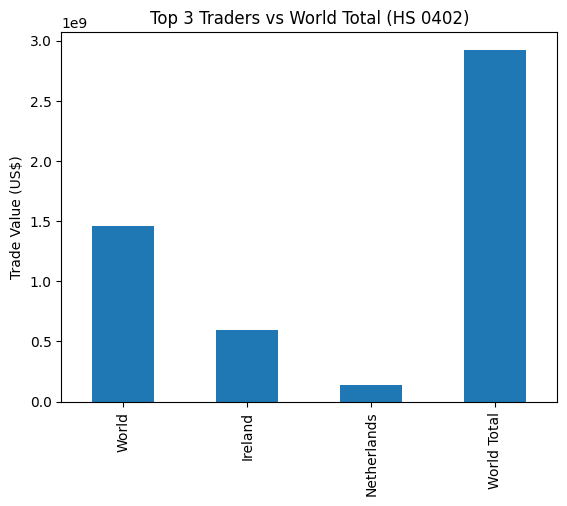

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

comparison = pd.concat([top3, pd.Series({"World Total": world_total})])

comparison.plot(kind="bar", title="Top 3 Traders vs World Total (HS 0402)")
plt.ylabel("Trade Value (US$)")
plt.show()

### Findings

The chart shows that while the top three trading countries account for a substantial share of HS 0402 trade, total world trade is significantly larger. This highlights the **global nature of dairy trade**, with many countries contributing smaller but collectively important trade flows.



## 6. Conclusion

This analysis demonstrates how monthly trade data can be used to examine both short-term fluctuations and broader seasonal patterns. For HS 0402, months with the highest average trade activity generally correspond to periods of sustained demand, while maximum monthly flows reflect isolated large transactions. The comparison of top trading partners with total world trade further emphasizes the concentration and dispersion of global trade relationships.




The trade in milk and cream between the United Kingdom and its international partners from **January to May 2015** was analysed to identify the countries on which the UK most strongly depends for **export income** and **imported goods**. Over this period, the UK recorded a **trade surplus exceeding 100 million US dollars**, indicating that export revenues significantly outweighed import expenditures for these products.

**Ireland emerged as the UK’s most important trading partner**. However, the relationship was notably asymmetric: Ireland imported almost **three times more milk and cream (by value)** from the UK than it exported to the UK. This highlights Ireland’s role primarily as a major export destination rather than a balanced trading partner.

During the period analysed, the UK exported milk and cream to **over 100 countries**, demonstrating a highly diversified export market. In contrast, imports were sourced from only **21 countries**, suggesting a far more concentrated import structure. The top five import partners, ranked by trade value, were all **geographically close to the UK**, reflecting the importance of proximity, transport costs, and regional supply chains in dairy trade. **China and Hong Kong** were notable exceptions, as they were significant importers of UK exports but not major exporters to the UK.

The analysis also revealed that the UK is **highly dependent on a core group of regular customers**. Sixteen countries imported all categories of milk and cream from the UK **every month** during the period studied. Collectively, these regular customers accounted for approximately **three quarters of the total export value**, underscoring their critical importance to the UK’s dairy export sector.

Finally, the UK engaged in **bi-directional trade** both importing from and exporting to **20 countries**. For several of these partners, however, the recorded trade values were extremely small. Such low values raise questions regarding **data accuracy, reporting thresholds, or classification inconsistencies**, suggesting that some transactions may be administrative artefacts rather than economically significant flows.




# LINK TO PUBLICATION

https://ehima.hashnode.dev/from-raw-trade-data-to-insight-what-i-learned-analysing-uk-milk-and-cream-trade-with-un-comtrade